# LSTM (장기 의존성 학습 모델)
- RNN 구조에서 발생하는 문제를 해결하기 위해 구조를 변경한 모델
- 기존의 RNN은 반복 학습을 하며 가중치의 변화량이 0에 가까워진다.
</br> = 학습 횟수가 증가하면 과거의 기억을 잃는다.
    - 손실 함수 -> tanh -> 반복적으로 tanh() 함수를 실행하게 되면 변화량 0
- LSTM은 반복 학습을 하면서 tanh()가 중복 실행되면 기울기 변화량 감소
    - 과거의 기억을 장기 기억과 단기 기억으로 나눠주는 역할
    - 장기 기억은 tanh() 함수를 실행하지 않아 가중치에 계속 변화를 준다.
    - '셀'이라는 공간에 장기 기억 정보를 전달
    - '게이트'로 정보를 선택적으로 보관, 삭제, 출력

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 데이터로드 
df = pd.read_csv("../csv/AAPL.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9715 entries, 0 to 9714
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9715 non-null   object 
 1   Open       9714 non-null   float64
 2   High       9714 non-null   float64
 3   Low        9714 non-null   float64
 4   Close      9714 non-null   float64
 5   Adj Close  9714 non-null   float64
 6   Volume     9713 non-null   float64
dtypes: float64(6), object(1)
memory usage: 531.4+ KB


In [3]:
# Date 컬럼의 dtype을 시계열 데이터로 변환
# 시각화 그래프에서 X축의 데이터로 사용하기 위해 문자형 -> 시계열 데이터로 변환
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
# 특정 컬럼 선택
df = df[['Date', 'Adj Close', 'Volume']]
# 결측치가 포함되어 있는 행을 모두 제거
df.dropna(axis=0, inplace=True)
# 인덱스 초기화 (KeyError 방지)
# df.reset_index(drop=True, inplace=True)

In [5]:
# 독립 데이터, 종속 데이터를 생성
X_all = df[['Adj Close', 'Volume']] # 피쳐 2개
Y_all = df[['Adj Close']]           # 피쳐 1개

In [6]:
# 데이터를 8:2 비율로 나눠준다.
split_idx = int(len(df) * 0.8)
X_train, X_test = X_all[ : split_idx], X_all[split_idx : ]
Y_train, Y_test = Y_all[ : split_idx], Y_all[split_idx : ]

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(7770, 2) (1943, 2)
(7770, 1) (1943, 1)


In [7]:
# 초기 설정값
# 시계열 데이터의 구간 수 (과거 데이터의 개수)
window = 60
# 학습 루프의 루프 수
epochs = 20
# 학습 데이터의 배치 수
x_batch = 64
# optimizer의 lr 값 (학습율)
lr= 0.001
# 은닉층의 뉴런 수
hidden_cnt = 64
# 은닉층과 셀 사용 여부
head_type = 'h'

In [8]:
class WindowDataset(Dataset):
    # 입력 데이터와 타깃 데이터를 받아 구간의 수만큼 입력 데이터를 잘라주고
    # 해당 구간의 데이터와 다음 행의 타깃 데이터를 되돌려준다.
    # => Dataloader 클래스에서 사용하기 위함
    def __init__( self, _x, _y, _window ):
        self.x = _x
        self.y = _y
        self.window = _window
        # n의 값은 구간의 데이터 시작 지점의 최댓값
        self.n = len(_x) - _window
    
    def __len__(self):
        # window의 수치가 x의 길이보다 큰 경우에는 1을 되돌려준다.
        return max(self.n, 1)
    
    def __getitem__(self, idx):
        # idx: 구간의 시작 지점 - 최댓값 self.n
        # idx부터 idx+window-1 위치까지의 데이터 -> (window, 2)
        x_window = self.x[ idx : idx+self.window ]
        # idx+window 위치의 데이터 -> 단일값 생성
        y_next = self.y[ idx+self.window ]
        # tensor형으로 변환
        x_tensor = torch.from_numpy(x_window)
        y_tensor = torch.from_numpy(y_next)
        return x_tensor, y_tensor

In [9]:
# 스케일링 - MinMaxScaler
x_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(Y_train)

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)
Y_train = y_scaler.transform(Y_train)
Y_test = y_scaler.transform(Y_test)

In [10]:
# WindowDataset class 생성
# 객체를 생성하고 getitem() 함수를 사용한다면
# window(60) 구간의 데이터와 해당 구간 다음 행의 종가 데이터를 되돌려주는 class
train_ds = WindowDataset(X_train, Y_train, window)
test_ds = WindowDataset(X_test, Y_test, window)

In [11]:
# DataLoader
# WindowDataset class를 이용
# ds_data에서 len() 함수를 사용하여 해당 구간에서 가장 마지막에 사용 가능한 시작 지점을 확인

train_dl = DataLoader(train_ds, shuffle=True, drop_last=True, batch_size=x_batch) # train 데이터의 shuffle=False라면 계속 같은 데이터로만 학습
test_dl = DataLoader(test_ds, shuffle=False, drop_last=False, batch_size=256)  # 검증할 때는 순서 유지

In [12]:
# i = 0
# for x, y in train_dl:
#     print("구간 데이터:", x)
#     # print("다음 날의 종가: ", y)
#     if i == 2:
#         break
#     i += 1

In [13]:
# LSTM 모델 정의
class LSTMReg(nn.Module):
    # h: 마지막 은닉층의 데이터를 이용 (RNN - 기억 소실, LSTM - 장기 기억)
    # c: 셀의 데이터를 이용
    # h_c: 은닉층 + 셀의 데이터를 이용
    def __init__(self,
                 input_size, hidden_size,
                 num_layers=1, dropout=0.0, # dropout: 다음 층으로 넘어갈 때 없앨 데이터 -> num_layers=1 일 때는 바꿔도 소용 X
                 bidirectional=False,  # 역방향
                 head_type = 'h'
                ):
        super().__init__()

        # lstm 기본 설정
        # batch_first 매개변수 
            # 기본값은 False
            # RNN, LSTM의 기본적인 입력값의 형태는 ( 구간의 수, 배치의 개수, 피쳐의 수 )
            # True로 변경시 ( 배치의 개수, 구간의 수, 피쳐의 수 )의 형태로 입력값을 확인
            # DataLoader에서 반환하는 데이터의 형태는 (배치의 개수, 구간의 수 피쳐의 수) 이기 때문에 
            # 해당 매개변수를 True로 변경
        self.lstm = nn.LSTM(
            input_size= input_size,
            hidden_size= hidden_size,
            num_layers= num_layers,
            dropout= dropout,
            bidirectional= bidirectional,
            batch_first=True
        )
        # bidirectional = True -> 차원의 개수 * 2 (순방향, 역방향 모두 고려)
        out_dim = hidden_size * (2 if bidirectional else 1)
        # head_type은 은닉층만 사용 or 셀만 사용 -> 차원의 개수 * 1
        if head_type in ['h', 'c']:
            head_in = out_dim
        elif head_type == 'h_c':
            head_in = out_dim * 2
        else:
            print('head_type Error')

        self.head = nn.Sequential(
            nn.Linear(head_in, 1)
        )
        self.head_type = head_type
    
    # 순전파 함수
    def forward(self, x):
        # 순전파의 예측 결괏값
        out, (h_n, c_n) = self.lstm(x)
        # 은닉층 중 마지막 은닉층을 저장        # 아래 생략하고 마지막 은닉층만 사용해도 결과 다름.
        h_last = h_n[-1]
        # 셀 중 마지막 셀을 저장
        c_last = torch.tanh(c_n[-1])
        
        if self.head_type == 'h':
            feat = h_last
        elif self.head_type == 'c':
            feat = c_last
        elif self.head_type == 'h_c':
            feat = torch.cat( [h_last, c_last], dim=-1 )  # pandas의 concat(단순결합)과 유사
        return self.head(feat)

In [14]:
# 순전파(학습->예측) -> 손실(예측을 검증) -> 역전파 -> 옵티마이저(순전파로 이동하면서 가중치의 변화)

# 모델을 생성
model = LSTMReg(input_size=2, hidden_size=hidden_cnt, head_type=head_type)
model

LSTMReg(
  (lstm): LSTM(2, 64, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [15]:
# 손실 함수 ->  회귀 모델(MSELoss) : 정답이 존재하지만 정확한 정답을 맞추기는 쉽지 않다. 오차
#             분류 모델(CrossEntropyLoss) : 정답을 정확하게 맞췄는가? -> 이진 분류, 다중 분류
criterion = nn.MSELoss()
# 가중치의 변화 (학습에 대한 가중을 변화)
# SGD(단순 경사 하강) -> 스탭 별 가중치의 변화량이 일정 
# Adam -> 학습율에 따른 동적인 가중치 변화
optimizer = optim.Adam(model.parameters(), lr = lr)

In [16]:
# Loss를 구하는 함수를 생성 -> torch의 모델은 자동 미분이 활성화를 비활성화로 바꾸고 작업 
# Loss의 값을 구하는 경우 루프가 끝나고 지정하기 때문에 미분 계산이 무의미 (비활성화)
# 계산이 비활성화가 되기 때문에 메모리 효율 증가, 속도 빨라진다. 
@torch.no_grad()
def evaluate_mse(dl):
    # eval() : 해당 모델의 평가 모드로 변환 
    model.eval()
    # 총 로스, 총 개수 초기 값 지정 
    total_loss = 0.0
    total_n = 0
    # Dataloader를 매개변수로 입력을 받아서 사용 -> barch_size의 개수만큼 데이터가 존재 
    for x, y in dl:
        # x -> 독립변수(문제) 
        # y -> 종속변수(답)
        # torch에서 계산은 float 형태에서 계산
        x = x.float()
        y = y.float()
        # 예측
        pred = model(x)
        # 예측 값과 실젯값의 loss 확인 
        loss = criterion(pred, y)   # 평균 손실 데이터 
        # 평균 손실 * y의 크기 -> 총 손실을 누적합 
        total_loss += loss.item() * y.size(0)
        # 총 개수을 누적합
        total_n += y.size(0)
    # 함수에서 되돌려주는 결과 값 -> total_loss / total_n
    # dl의 barch_size가 0인경우라면 -> 0 / 0 --> Error 발생 -> 분모는 max() 이용
    return total_loss / max(total_n, 1)

In [17]:
# 학습 루프 (반복 학습) : (순전파 -> 손실 -> 역전파 -> 옵티마이저) -> 하나의 스탭 
# loss의 값의 변화를 저장 
train_history = []
test_history = []

# 반복 횟수에 따른 반복문이 생성 
for epoch in range(epochs):
    # 모델의 학습 모드 변환
    model.train()
    # 총 손실에 대한 평균을 구하기 위해서 총 로스, 총 개수의 초기값을 설정
    tot_loss = 0.0
    tot_n = 0
    # train인 DataLoader를 이용하여 반복문을 실행 
    for x, y in train_dl:
        x = x.float()
        y = y.float()

        # 학습 루프가 반복적으로 실행이 되기 때문에 미분의 값을 초기화
        optimizer.zero_grad()
        # 모델에 학습 데이터를 학습하여 예측
        pred = model(x)
        # 예측값과 실젯값의 차이를 계산
        loss = criterion(pred, y)
        # 역전
        loss.backward()
        # 기울기 너무 급격하게 변화해서 폭주하는 상황은 방지 
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # 총 손실의 누적합 
        tot_loss += loss.item() * y.size(0)
        # 총 개수의 누적합 
        tot_n += y.size(0)
    
    # train 데이터에 총 loss의 평균 
    train_loss = tot_loss / max(tot_n , 1)
    # test 데이터에 총 loss의 평균
    # 학습모드와 평가모드를 루프에서 동시에 사용하는 이유는 -> 과적합 방지 
    test_loss = evaluate_mse(test_dl)
    # loss의 내역을 저장 
    train_history.append(train_loss)
    test_history.append(test_loss)
    print(f"Epoch : {epoch + 1}, train_mse : {round(train_loss, 4)}, \
          test_mse : {round(test_loss, 4)}")

Epoch : 1, train_mse : 0.015,           test_mse : 1.1271
Epoch : 2, train_mse : 0.0002,           test_mse : 1.006
Epoch : 3, train_mse : 0.0002,           test_mse : 0.8795
Epoch : 4, train_mse : 0.0001,           test_mse : 0.7784
Epoch : 5, train_mse : 0.0001,           test_mse : 0.7202
Epoch : 6, train_mse : 0.0001,           test_mse : 0.6569
Epoch : 7, train_mse : 0.0001,           test_mse : 0.5934
Epoch : 8, train_mse : 0.0001,           test_mse : 0.5824
Epoch : 9, train_mse : 0.0001,           test_mse : 0.5365
Epoch : 10, train_mse : 0.0001,           test_mse : 0.4735
Epoch : 11, train_mse : 0.0001,           test_mse : 0.4485
Epoch : 12, train_mse : 0.0001,           test_mse : 0.4329
Epoch : 13, train_mse : 0.0001,           test_mse : 0.3923
Epoch : 14, train_mse : 0.0001,           test_mse : 0.3829
Epoch : 15, train_mse : 0.0001,           test_mse : 0.3514
Epoch : 16, train_mse : 0.0001,           test_mse : 0.3438
Epoch : 17, train_mse : 0.0001,           test_mse 

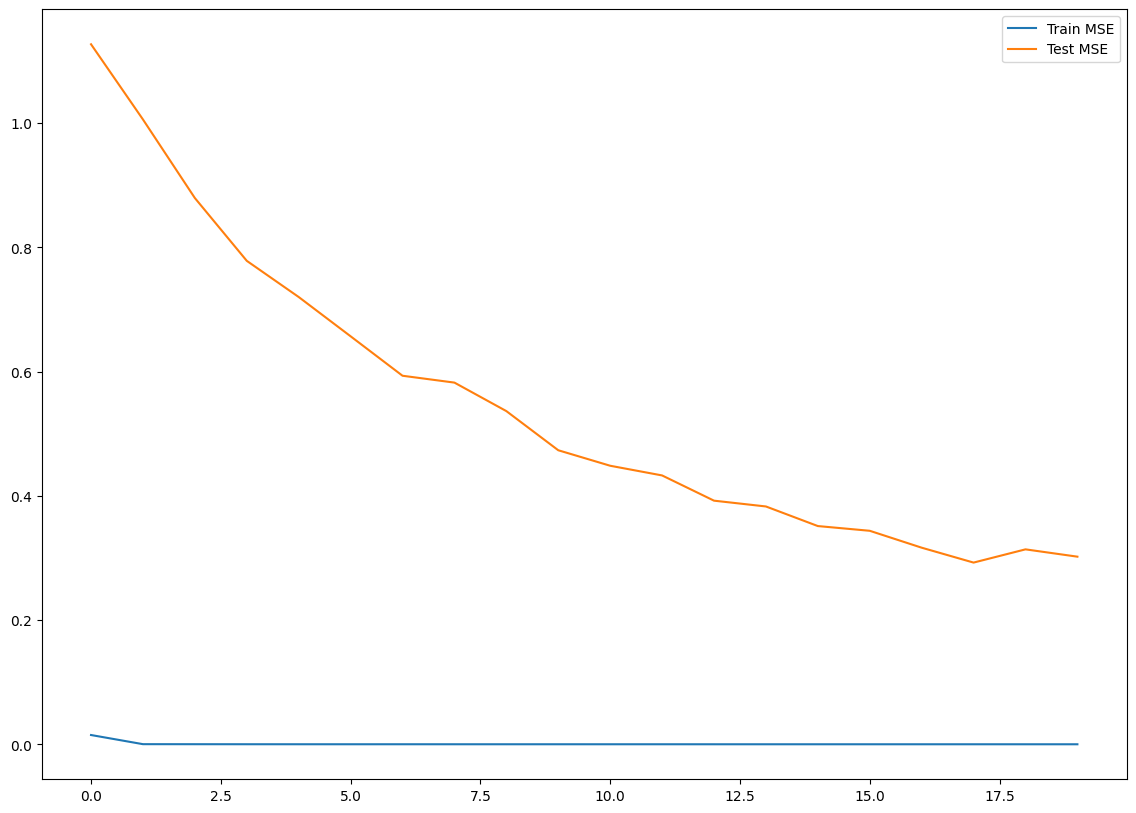

In [18]:
# train_mse와 test_mse의 변화량을 그래프 확인 
# 학습 곡선을 확인 

plt.figure(figsize=(14, 10))

plt.plot(train_history, label= 'Train MSE')
plt.plot(test_history, label ='Test MSE')
plt.legend()
plt.show()

In [19]:
# 검증 예측 , 실제 값을 그래프로 시각화 
model.eval()
# 예측 값, 실제 값을 1차원 리스트에 대입
preds = []
trues = []

with torch.no_grad():
    for x, y in test_dl:
        x = x.float()
        pred = model(x).cpu()
        preds.append(pred)
        trues.append(y)
preds = torch.cat(preds, dim=0).squeeze(-1).numpy()
trues = torch.cat(trues, dim=0).squeeze(-1).numpy()
# preds, tures 아직 스케일링이 되어있는 상태

# 데이터의 역변환
preds_origin = y_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
trues_origin = y_scaler.inverse_transform(trues.reshape(-1, 1)).squeeze()

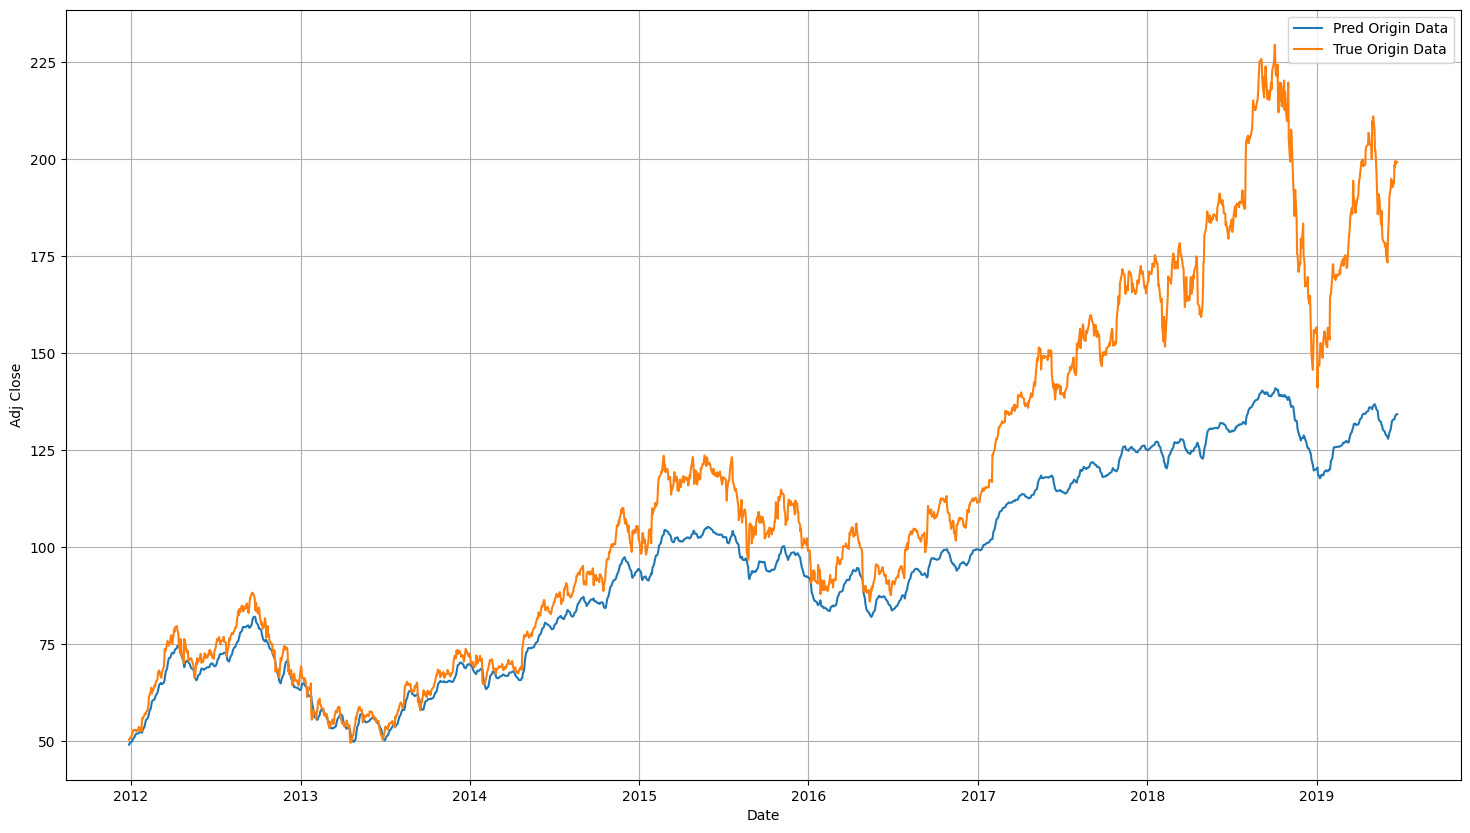

In [20]:
plt.figure(figsize=(18, 10))
# x축에서 사용될 시간축 데이터를 로드 
x_data = df['Date'].values[split_idx + window : ]

plt.plot(x_data, preds_origin, label='Pred Origin Data')
plt.plot(x_data, trues_origin, label='True Origin Data')

plt.legend()
plt.grid(True)
plt.ylabel('Adj Close')
plt.xlabel('Date')

plt.show()

In [21]:
# 해당 데이터셋에서 존재하지 않는 다음날의 수정 종가를 확인 (미래 예측)
# 데이터셋에서 영업일 기준 60일치 마지막 부분의 데이터를 필터링 
# feat_last = df[['Adj Close', 'Volume']].astype('float').values[-window : ]
feat_last = df[['Adj Close', 'Volume']].tail(window).values
# 스케일링 -> 스케일러 선택(x_scaler)
fear_last_sc = x_scaler.transform(feat_last)
type(fear_last_sc)

c:\Users\student\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


numpy.ndarray

In [22]:
import numpy as np

In [23]:
# model에 데이터를 대입하여 예측을 만들기 위해서는 LSTM에서 입력으로 사용이 될 데이터셋으로 변환
# tensor형 데이터로 변환 -> (batch_size, window, n_feafures) 크기 
# (1, 60, 2)
x_input = torch.from_numpy(fear_last_sc.astype(np.float32)).unsqueeze(0)

In [24]:
# 모델을 평가 모드로 변환 
model.eval()

with torch.no_grad():
    y_pred_sc = model(x_input).numpy()
y_pred_sc

array([[2.6018355]], dtype=float32)

In [25]:
# 원본의 데이터셋으로 역변환 -> 스케일링이 된 수정 종가 데이터를 원본의 형태로 변환
# 스케일러 선택은? 종속의 스케일러를 선택 
last_pred = y_scaler.inverse_transform(y_pred_sc)[0, 0]
last_pred

np.float32(134.37265)